# **Kütüphane Import'ları**

In [ ]:
!pip install gradio

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import pickle
import gradio as gr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/BigData Proje/gtd_db.xlsx'
df = pd.read_excel(file_path, sheet_name="Data", engine="openpyxl")

Mounted at /content/drive


# **Veri Temizliği**

In [ ]:
df.shape

(209706, 135)

In [ ]:
df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaT,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaT,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaT,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaT,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaT,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


In [ ]:
threshold = 0.9
missing_ratio = df.isnull().sum() / len(df)
cols_to_drop = missing_ratio[missing_ratio > threshold].index.tolist()
df = df.drop(columns=cols_to_drop)

In [ ]:
# Eksik oranlarını hesapla
missing_ratio = df.isnull().mean().sort_values(ascending=False)

# %30'dan fazla eksik olan sütunları kaldır
high_missing_cols = missing_ratio[missing_ratio > 0.3].index
df.drop(columns=high_missing_cols, inplace=True)

# **Hedef Değişkenler ve Label Encoding**

In [ ]:
# Kullanılacak sütunlar
features = ['iyear', 'country_txt', 'attacktype1_txt',
            'targtype1_txt', 'weaptype1_txt', 'nkill',
            'nwound', 'property', 'success', 'suicide']

df_model = df[features + ['gname']].copy()

categorical_cols = ['country_txt', 'attacktype1_txt', 'targtype1_txt', 'weaptype1_txt']

# Hedef değişkende "Unknown" ya da "Unaffiliated Individual(s)" olanları çıkar
df_model = df_model[~df_model['gname'].isin(['Unknown', 'Unaffiliated Individual(s)'])]

df_model['nkill'] = df_model['nkill'].fillna(0)
df_model['nwound'] = df_model['nwound'].fillna(0)

for col in categorical_cols:
    df_model[col] = df_model[col].fillna("Unknown")

df_model['property'] = df_model['property'].fillna(0)
df_model['success'] = df_model['success'].fillna(0)
df_model['suicide'] = df_model['suicide'].fillna(0)

# Kategorik sütunları LabelEncoder ile sayıya çevir
label_encoders = {}
label_mappings = {}
for col in categorical_cols + ['gname']:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le
    label_mappings[col] = dict(zip(le.transform(le.classes_), le.classes_))

# LabelEncoder nesnelerini kaydet
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

# Kod-etiket eşleşmelerini kaydet
with open('label_mappings.pkl', 'wb') as f:
    pickle.dump(label_mappings, f)

In [ ]:
df_model.shape

(117800, 11)

# **En Aktif 50 Örgütün Filtrelenmesi**

In [ ]:
top_groups = df_model['gname'].value_counts().nlargest(50).index
df_model_filtered = df_model[df_model['gname'].isin(top_groups)]

In [ ]:
print(df_model_filtered.shape)

(79860, 11)


# **Korelasyon Matrisi**

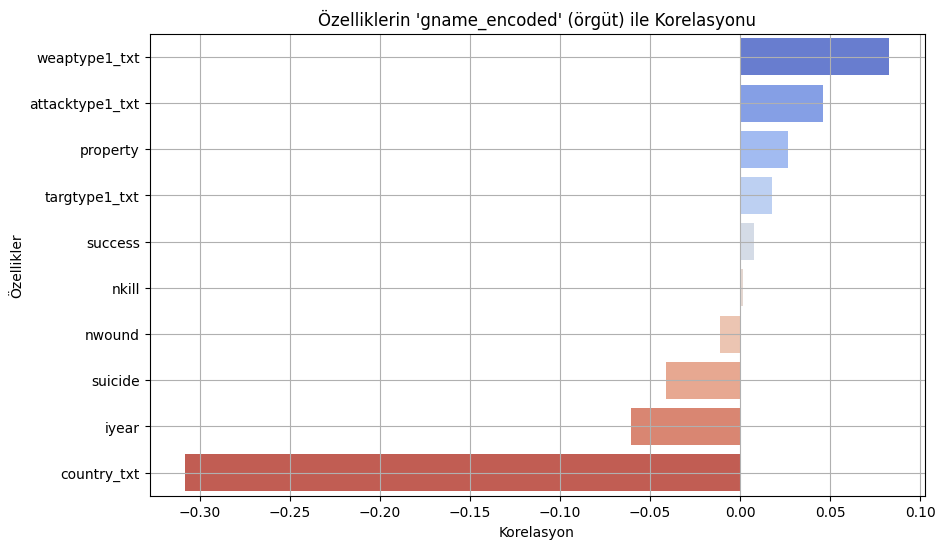

Hedefle en çok ilişkili ilk 8 özellik:
weaptype1_txt      0.082909
attacktype1_txt    0.045820
property           0.026568
targtype1_txt      0.017641
success            0.007924
nkill              0.001508
nwound            -0.011005
suicide           -0.040996
Name: gname, dtype: float64


In [ ]:
corr_matrix = df_model.corr(numeric_only=True)

target_corr = corr_matrix['gname'].drop('gname').sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm")
plt.title("Özelliklerin 'gname_encoded' (örgüt) ile Korelasyonu")
plt.xlabel("Korelasyon")
plt.ylabel("Özellikler")
plt.grid(True)
plt.show()

print("Hedefle en çok ilişkili ilk 8 özellik:")
print(target_corr.head(8))

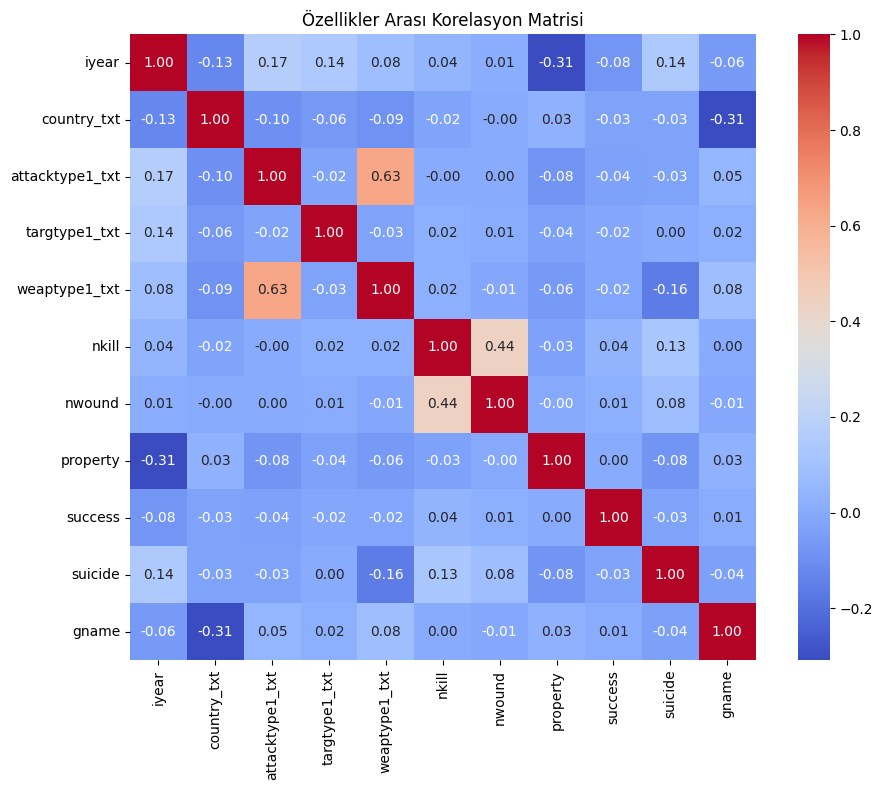

In [ ]:
corr_matrix = df_model.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("Özellikler Arası Korelasyon Matrisi")
plt.tight_layout()
plt.show()

# **Train Test Split**

In [ ]:
# Özellik ve hedef ayrımı
X = df_model_filtered.drop('gname', axis=1)
y = df_model_filtered['gname']

# Veriyi eğitim ve test olarak ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Random Forest Model Eğitimi**

In [ ]:
# Modeli kur ve eğit
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Tahmin
y_pred = rf.predict(X_test)

In [ ]:
# Doğruluk
print("Accuracy:", accuracy_score(y_test, y_pred))

# Hassasiyet, Duyarlılık, F1 Skoru
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

# Karışıklık Matrisi
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Daha detaylı sınıf bazlı rapor
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8909967443025294
Precision: 0.886695352657728
Recall: 0.8909967443025294
F1 Score: 0.8870093183072976
Confusion Matrix:
 [[ 56   0   0 ...   0   0   0]
 [  0 125   0 ...   0   0   0]
 [  0   0 130 ...   0   0   0]
 ...
 [  0   0   0 ...  62   0   0]
 [  0   0   0 ...   0  26   0]
 [  0   0   1 ...   0   0  46]]
Classification Report:
               precision    recall  f1-score   support

          49       0.55      0.43      0.48       130
          87       0.99      0.95      0.97       131
         173       0.92      0.90      0.91       144
         176       0.81      0.81      0.81       218
         184       0.96      0.99      0.97       896
         215       0.97      1.00      0.99        70
         236       0.84      0.90      0.87        70
         633       0.43      0.35      0.39       105
         650       0.97      0.98      0.98       406
         740       0.89      0.90      0.89       635
         819       0.97      0.95      0.96        76
  


Top 10 important features:
country_txt        0.599440
iyear              0.166462
targtype1_txt      0.066386
nkill              0.044699
nwound             0.036339
attacktype1_txt    0.028406
weaptype1_txt      0.025546
property           0.019253
success            0.007739
suicide            0.005729
dtype: float64


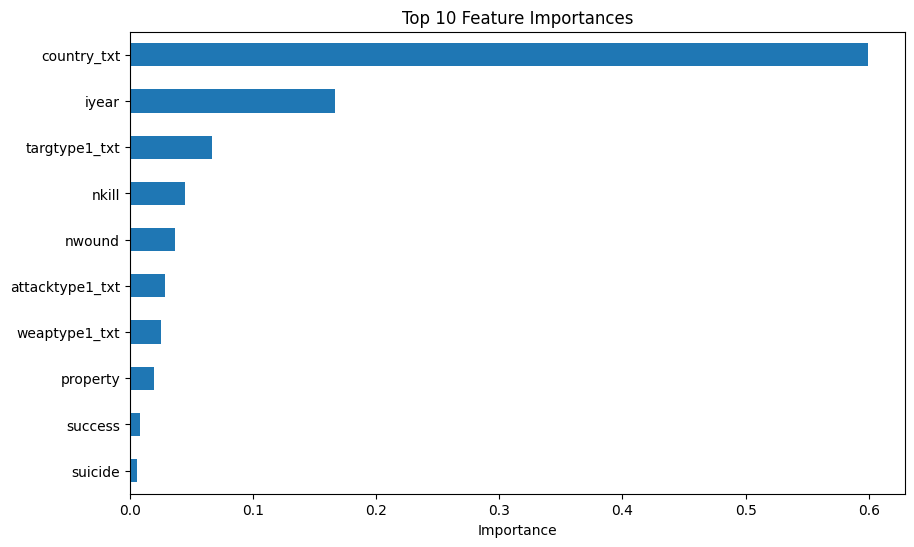

In [ ]:
importances = rf.feature_importances_

if hasattr(X_train, 'columns'):
    feature_names = X_train.columns
else:
    feature_names = [f'Feature {i}' for i in range(X_train.shape[1])]

feat_importances = pd.Series(importances, index=feature_names)

# En önemli 10 özelliği sırala
top_n = 10
top_features = feat_importances.sort_values(ascending=False).head(top_n)

print(f"\nTop {top_n} important features:")
print(top_features)

plt.figure(figsize=(10,6))
top_features.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.show()

# **K-Nearest Neighbors (KNN)**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("K-Nearest Neighbors")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_knn, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_knn, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

K-Nearest Neighbors
Accuracy: 0.7650489967335511
Precision: 0.7597876962575696
Recall: 0.7650489967335511
F1 Score: 0.7606469968498792
Confusion Matrix:
 [[   29     0     0 ...     0     0    27]
 [    0    91     0 ...     0     0    28]
 [    0     0    13 ...     0     0    89]
 ...
 [    0     0     0 ...    19     0     5]
 [    0     0     0 ...     0    20    51]
 [   18    26    38 ...     9    17 15106]]
Classification Report:
               precision    recall  f1-score   support

          49       0.37      0.24      0.29       120
          87       0.76      0.76      0.76       120
         173       0.24      0.12      0.16       110
         176       0.57      0.52      0.54       219
         184       0.81      0.88      0.85       879
         215       0.68      0.63      0.65        67
         236       0.71      0.79      0.74       107
         633       0.30      0.29      0.30       106
         650       0.74      0.87      0.80       407
         740     

# **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_dt, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_dt, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

Decision Tree
Accuracy: 0.763590760615959
Precision: 0.7670571912920048
Recall: 0.763590760615959
F1 Score: 0.7648236113629682
Confusion Matrix:
 [[   37     0     0 ...     0     0    35]
 [    0    81     0 ...     0     0    39]
 [    0     0    35 ...     0     0    73]
 ...
 [    0     0     0 ...    27     0     3]
 [    0     0     0 ...     0    22    38]
 [   32    29   126 ...     9    35 14740]]
Classification Report:
               precision    recall  f1-score   support

          49       0.31      0.31      0.31       120
          87       0.74      0.68      0.70       120
         173       0.21      0.32      0.26       110
         176       0.57      0.58      0.58       219
         184       0.84      0.89      0.87       879
         215       0.65      0.66      0.65        67
         236       0.73      0.84      0.78       107
         633       0.31      0.30      0.31       106
         650       0.84      0.89      0.86       407
         740       0.75  

# **GridSearch ile En İyi Parametre Ayarlamaları**

In [ ]:
# Parametre aralıkları
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

In [ ]:
# GridSearchCV modeli (5-fold cross validation)
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Eğit
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

In [ ]:
# En iyi sonuçlar
print("En iyi parametreler:", grid_search.best_params_)

En iyi parametreler: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
# En iyi modelle tahmin yap
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Doğruluk
print("Accuracy:", accuracy_score(y_test, y_pred_best))

# Hassasiyet, Duyarlılık, F1 Skoru
print("Precision:", precision_score(y_test, y_pred_best, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_best, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_best, average='weighted'))

# Karışıklık Matrisi
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

# Daha detaylı sınıf bazlı rapor
print("Classification Report:\n", classification_report(y_test, y_pred_best))

Accuracy: 0.8965689957425494
Precision: 0.8925943758447261
Recall: 0.8965689957425494
F1 Score: 0.8904188093575357
Confusion Matrix:
 [[ 51   0   0 ...   0   0   0]
 [  0 124   0 ...   0   0   0]
 [  0   0 129 ...   0   0   0]
 ...
 [  1   0   0 ...  62   0   0]
 [  0   0   0 ...   0  18   0]
 [  0   0   1 ...   0   0  44]]
Classification Report:
               precision    recall  f1-score   support

          49       0.66      0.39      0.49       130
          87       0.98      0.95      0.96       131
         173       0.94      0.90      0.92       144
         176       0.83      0.82      0.82       218
         184       0.96      0.99      0.98       896
         215       0.97      0.99      0.98        70
         236       0.86      0.81      0.84        70
         633       0.51      0.32      0.40       105
         650       0.97      0.98      0.98       406
         740       0.89      0.90      0.89       635
         819       0.99      0.96      0.97        76
 

# **En İyi Modeli Kaydetme**

In [ ]:
# En iyi modeli kaydet
with open("best_random_forest_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Model başarıyla 'best_random_forest_model.pkl' dosyasına kaydedildi.")

Model başarıyla 'best_random_forest_model.pkl' dosyasına kaydedildi.


# **En İyi Model İçin Karışıklık Matrisi (İlk 10 Örgüt)**

In [ ]:
with open("label_mappings.pkl", "rb") as f:
    label_mappings = pickle.load(f)

class_mapping = label_mappings['gname']

top_10_ids = df_model['gname'].value_counts().nlargest(10).index.tolist()
top_10_names = [class_mapping[i] for i in top_10_ids]

In [ ]:
mask = np.isin(y_test, top_10_ids)
y_test_top10 = y_test[mask]
y_pred_top10 = y_pred_best[mask]

In [ ]:
short_names = {
    "Taliban": "Taliban",
    "Islamic State of Iraq and the Levant (ISIL)": "ISIL",
    "Shining Path (SL)": "SL",
    "Al-Shabaab": "Al-Shabaab",
    "New People's Army (NPA)": "NPA",
    "Farabundo Marti National Liberation Front (FMLN)": "FMLN",
    "Boko Haram": "Boko Haram",
    "Houthi extremists (Ansar Allah)": "Houthi",
    "Irish Republican Army (IRA)": "IRA",
    "Kurdistan Workers' Party (PKK)": "PKK"
}

short_top_10_names = [short_names[name] for name in top_10_names]

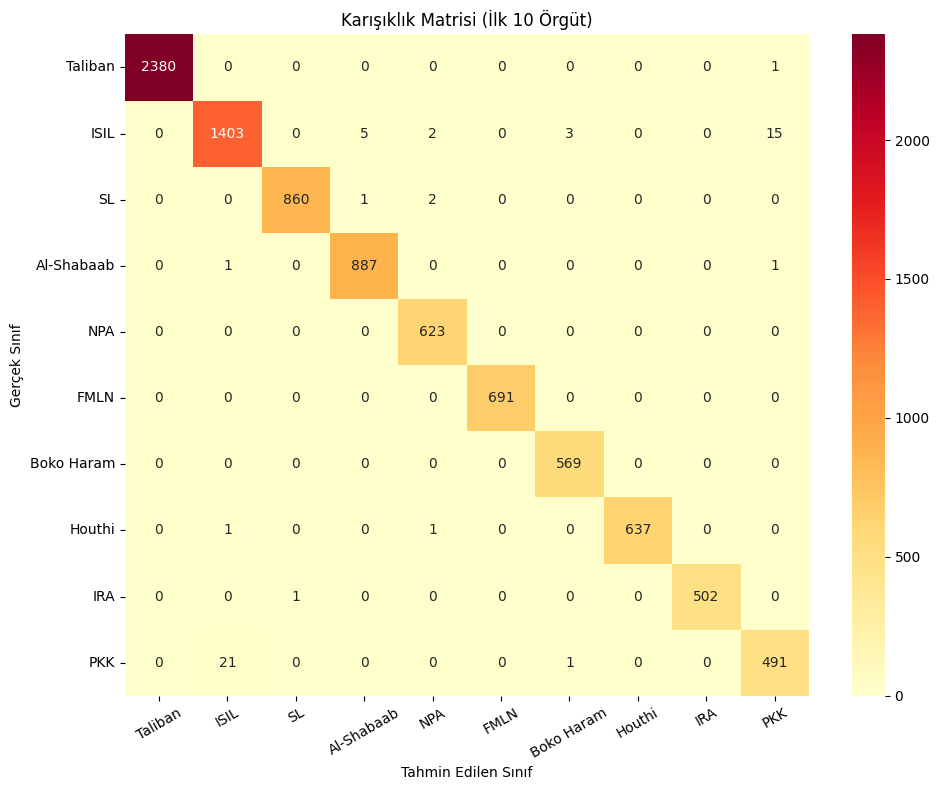

In [ ]:
cm = confusion_matrix(y_test_top10, y_pred_top10, labels=top_10_ids)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=short_top_10_names, yticklabels=short_top_10_names)
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.title("Karışıklık Matrisi (İlk 10 Örgüt)")
plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# **Gradio İle Arayüz Gerçeklemesi**

In [ ]:
with open("best_random_forest_model.pkl", "rb") as f:
    model = pickle.load(f)

with open("label_encoders.pkl", "rb") as f:
    label_encoders = pickle.load(f)

with open("label_mappings.pkl", "rb") as f:
    label_mappings = pickle.load(f)

input_labels = {
    "iyear": gr.Number(label="Yıl (iyear)", value=2015),
    "country_txt": gr.Dropdown(choices=label_mappings['country_txt'].values(), label="Ülke"),
    "attacktype1_txt": gr.Dropdown(choices=label_mappings['attacktype1_txt'].values(), label="Saldırı Türü"),
    "targtype1_txt": gr.Dropdown(choices=label_mappings['targtype1_txt'].values(), label="Hedef Türü"),
    "weaptype1_txt": gr.Dropdown(choices=label_mappings['weaptype1_txt'].values(), label="Silah Türü"),
    "nkill": gr.Number(label="Ölü Sayısı", value=0),
    "nwound": gr.Number(label="Yaralı Sayısı", value=0),
    "property": gr.Checkbox(label="Maddi Hasar Var mı?"),
    "success": gr.Checkbox(label="Saldırı Başarılı mı?"),
    "suicide": gr.Checkbox(label="İntihar Saldırısı mı?")
}

In [ ]:
def predict_group(
    iyear, country_txt, attacktype1_txt, targtype1_txt, weaptype1_txt,
    nkill, nwound, property, success, suicide
):
    input_dict = {
        "iyear": iyear,
        "country_txt": label_encoders['country_txt'].transform([country_txt])[0],
        "attacktype1_txt": label_encoders['attacktype1_txt'].transform([attacktype1_txt])[0],
        "targtype1_txt": label_encoders['targtype1_txt'].transform([targtype1_txt])[0],
        "weaptype1_txt": label_encoders['weaptype1_txt'].transform([weaptype1_txt])[0],
        "nkill": nkill,
        "nwound": nwound,
        "property": int(property),
        "success": int(success),
        "suicide": int(suicide)
    }

    features = list(input_dict.keys())
    X_input = np.array([input_dict[feat] for feat in features]).reshape(1, -1)

    pred_index = model.predict(X_input)[0]
    pred_proba = model.predict_proba(X_input)[0]
    confidence = np.max(pred_proba) * 100

    gname = label_encoders['gname'].inverse_transform([pred_index])[0]

    return f"🎯 **Tahmin Edilen Terörist Grup:** `{gname}`\n🔒 **Model Güveni:** %{confidence:.2f}"

In [ ]:
demo = gr.Interface(
    fn=predict_group,
    inputs=list(input_labels.values()),
    outputs=gr.Markdown(label="Tahmin Sonucu"),
    title="🕵️‍♂️ Terörist Grup Tahmini Aracı",
    description="Girdiğiniz saldırı bilgilerine göre model tahmini grubu ve güven skorunu gösterir.",
    theme="soft"
)

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1b8e96778864456d2f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **Veri Analizi**

In [ ]:
terror = df.copy()
terror.rename(columns={'iyear':'Year','imonth':'Month','iday':'Day','country_txt':'Country','region_txt':'Region','attacktype1_txt':'AttackType','target1':'Target','nkill':'Killed','nwound':'Wounded','summary':'Summary','gname':'Group','targtype1_txt':'Target_type','weaptype1_txt':'Weapon_type','motive':'Motive'},inplace=True)
terror=terror[['Year','Month','Day','Country','Region','city','latitude','longitude','AttackType','Killed','Wounded','Target','Summary','Group','Target_type','Weapon_type','Motive']]
terror['casualities']=terror['Killed']+terror['Wounded']

In [ ]:
print("Veri Seti Boyutu:", terror.shape)
print("\nEksik Değerler:")
print(terror.isnull().sum())

Veri Seti Boyutu: (209706, 18)

Eksik Değerler:
Year                0
Month               0
Day                 0
Country             0
Region              0
city              427
latitude         4691
longitude        4692
AttackType          0
Killed          12527
Wounded         19936
Target            637
Summary         66120
Group               0
Target_type         0
Weapon_type         0
Motive         154648
casualities     20657
dtype: int64


## **Yıllara Göre Terör Olayı Sayısı**

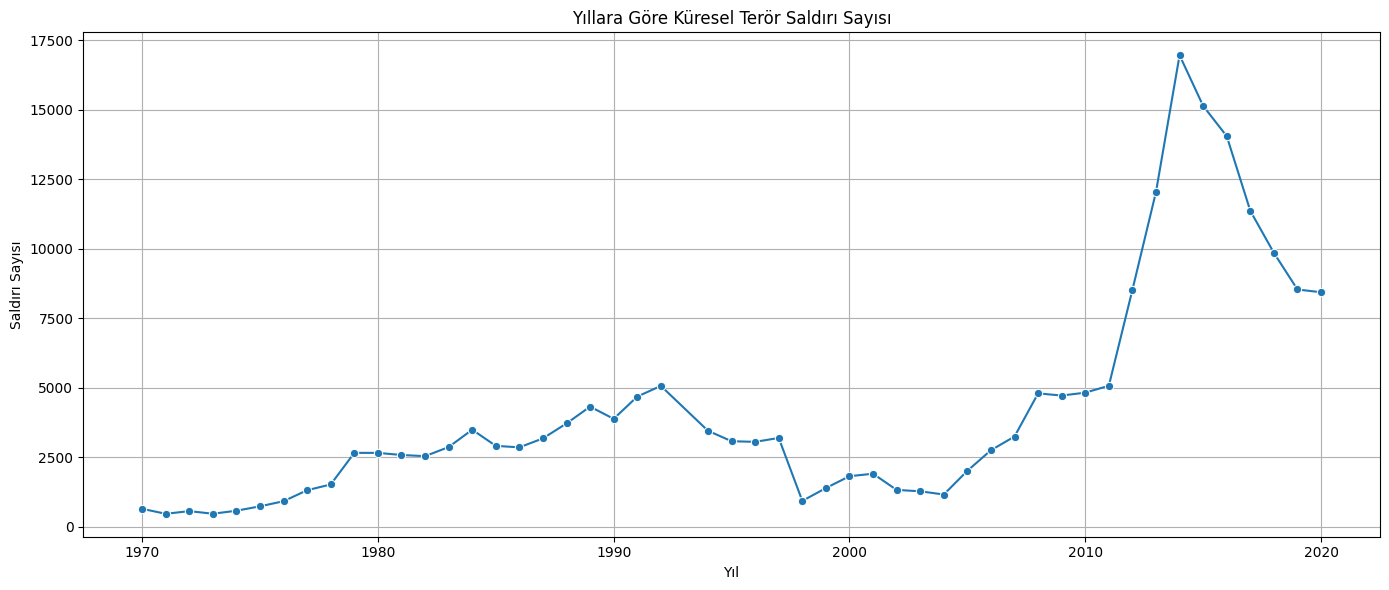

In [ ]:
attacks_by_year = terror['Year'].value_counts().sort_index()
plt.figure(figsize=(14,6))
sns.lineplot(x=attacks_by_year.index, y=attacks_by_year.values, marker='o')
plt.title('Yıllara Göre Küresel Terör Saldırı Sayısı')
plt.xlabel('Yıl')
plt.ylabel('Saldırı Sayısı')
plt.grid(True)
plt.tight_layout()
plt.show()

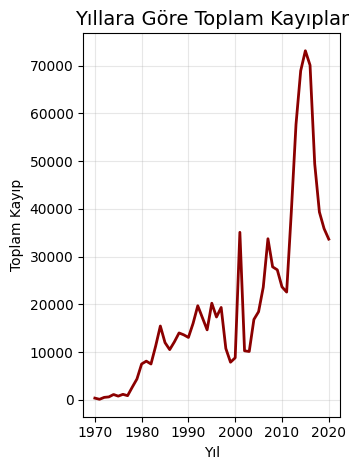

In [ ]:
plt.subplot(1, 2, 2)
yearly_casualties = terror.groupby('Year')['casualities'].sum()
yearly_casualties.plot(kind='line', color='darkred', linewidth=2)
plt.title('Yıllara Göre Toplam Kayıplar', fontsize=14)
plt.xlabel('Yıl')
plt.ylabel('Toplam Kayıp')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## **En Çok Saldırıya Uğrayan Ülkeler**

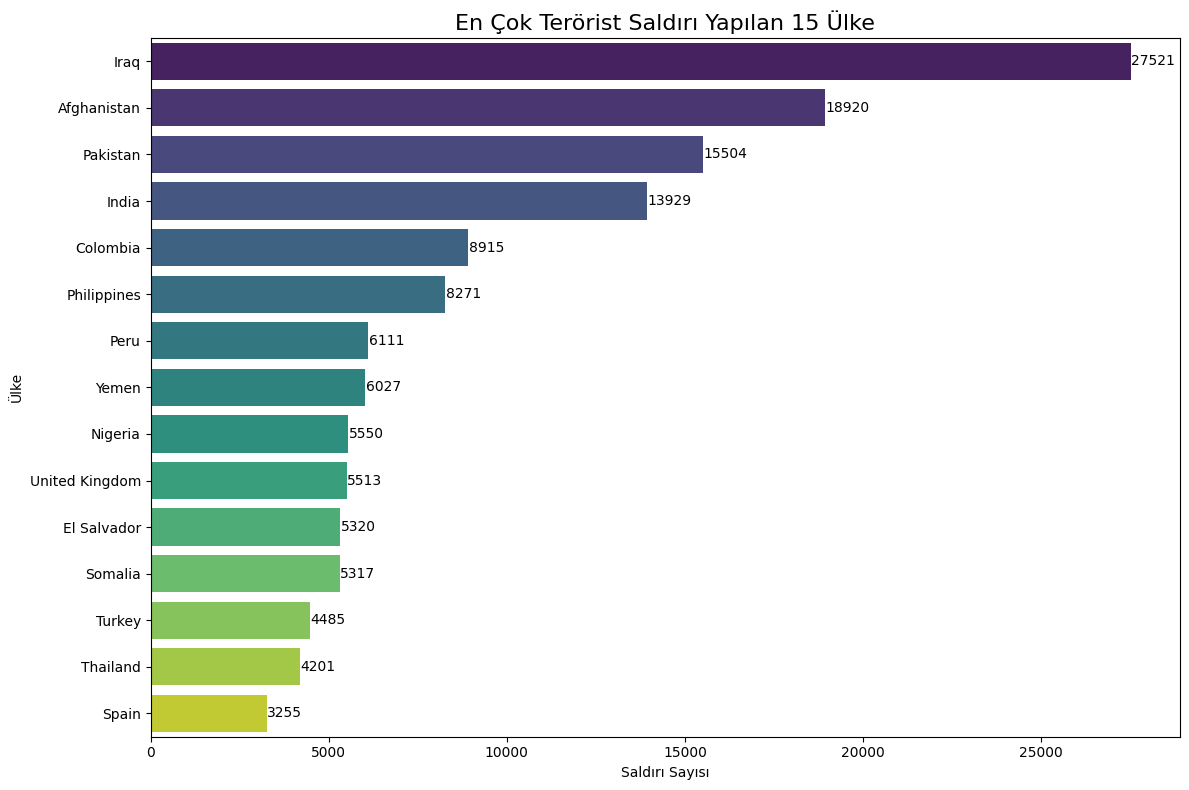

En Çok Saldırı Yapılan İlk 10 Ülke:
Country
Iraq              27521
Afghanistan       18920
Pakistan          15504
India             13929
Colombia           8915
Philippines        8271
Peru               6111
Yemen              6027
Nigeria            5550
United Kingdom     5513
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(12, 8))
top_countries = terror['Country'].value_counts().head(15)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.title('En Çok Terörist Saldırı Yapılan 15 Ülke', fontsize=16)
plt.xlabel('Saldırı Sayısı')
plt.ylabel('Ülke')
for i, v in enumerate(top_countries.values):
    plt.text(v + 10, i, str(v), va='center')
plt.tight_layout()
plt.show()

print("En Çok Saldırı Yapılan İlk 10 Ülke:")
print(top_countries.head(10))

## **Saldırı Tipleri Analizi**

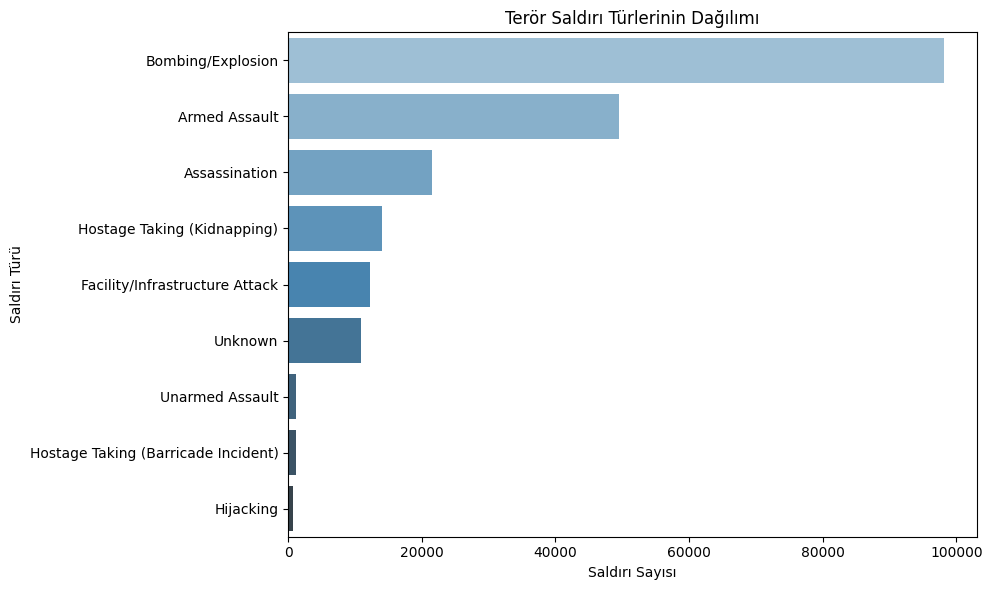

In [ ]:
attack_type_counts = terror['AttackType'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=attack_type_counts.values, y=attack_type_counts.index, palette='Blues_d')
plt.title('Terör Saldırı Türlerinin Dağılımı')
plt.xlabel('Saldırı Sayısı')
plt.ylabel('Saldırı Türü')
plt.tight_layout()
plt.show()

## **Küresel Can Kaybı**

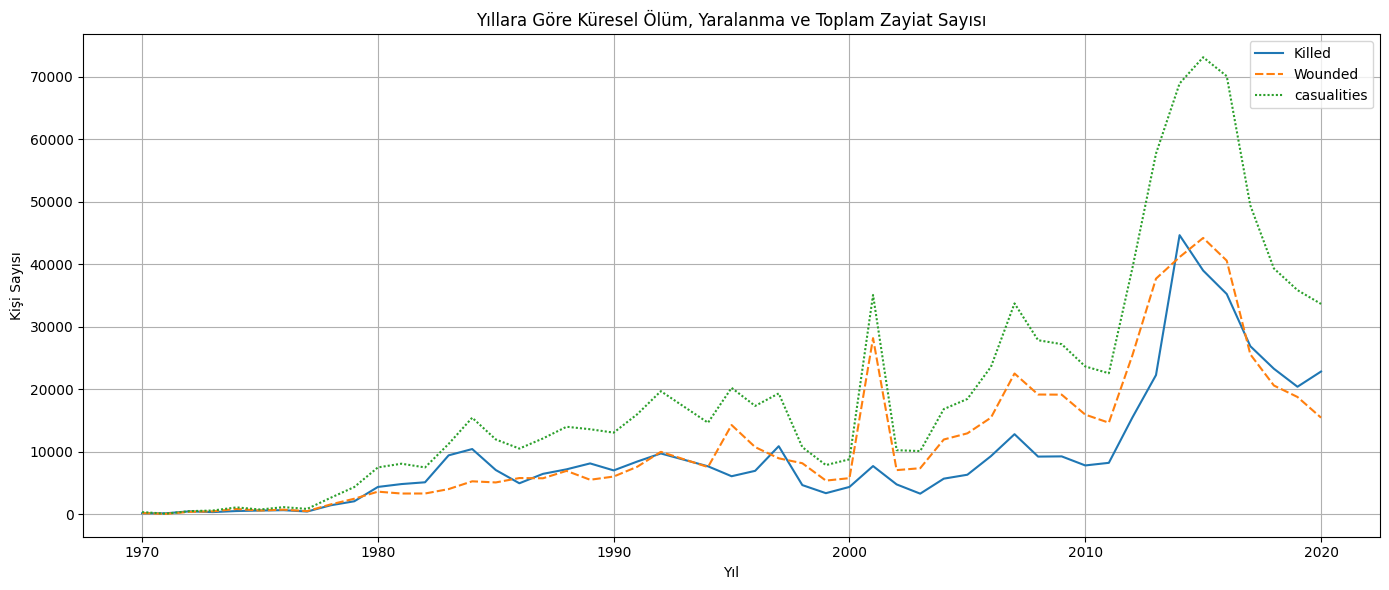

In [ ]:
casualty_trend = terror.groupby('Year')[['Killed', 'Wounded', 'casualities']].sum()
plt.figure(figsize=(14,6))
sns.lineplot(data=casualty_trend)
plt.title('Yıllara Göre Küresel Ölüm, Yaralanma ve Toplam Zayiat Sayısı')
plt.xlabel('Yıl')
plt.ylabel('Kişi Sayısı')
plt.grid(True)
plt.tight_layout()
plt.show()

## **En Aktif Terör Örgütleri**

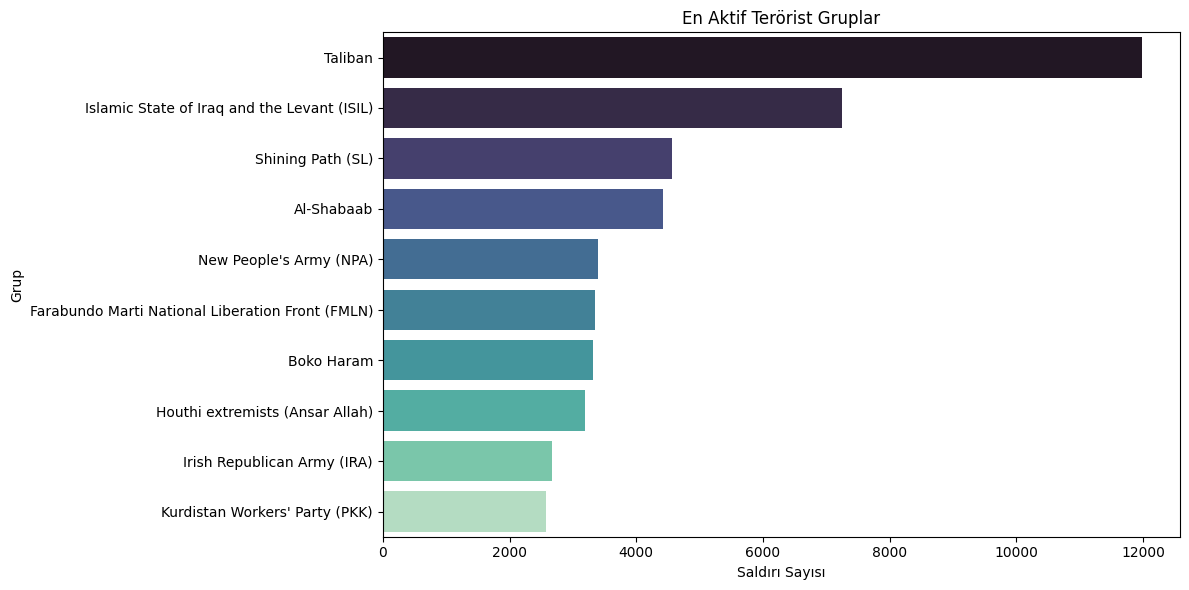

In [ ]:
top_groups = terror[terror['Group'] != 'Unknown']['Group'].value_counts().head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=top_groups.values, y=top_groups.index, palette='mako')
plt.title('En Aktif Terörist Gruplar')
plt.xlabel('Saldırı Sayısı')
plt.ylabel('Grup')
plt.tight_layout()
plt.show()

## **Bölgelere Göre Saldırı Dağılımı**

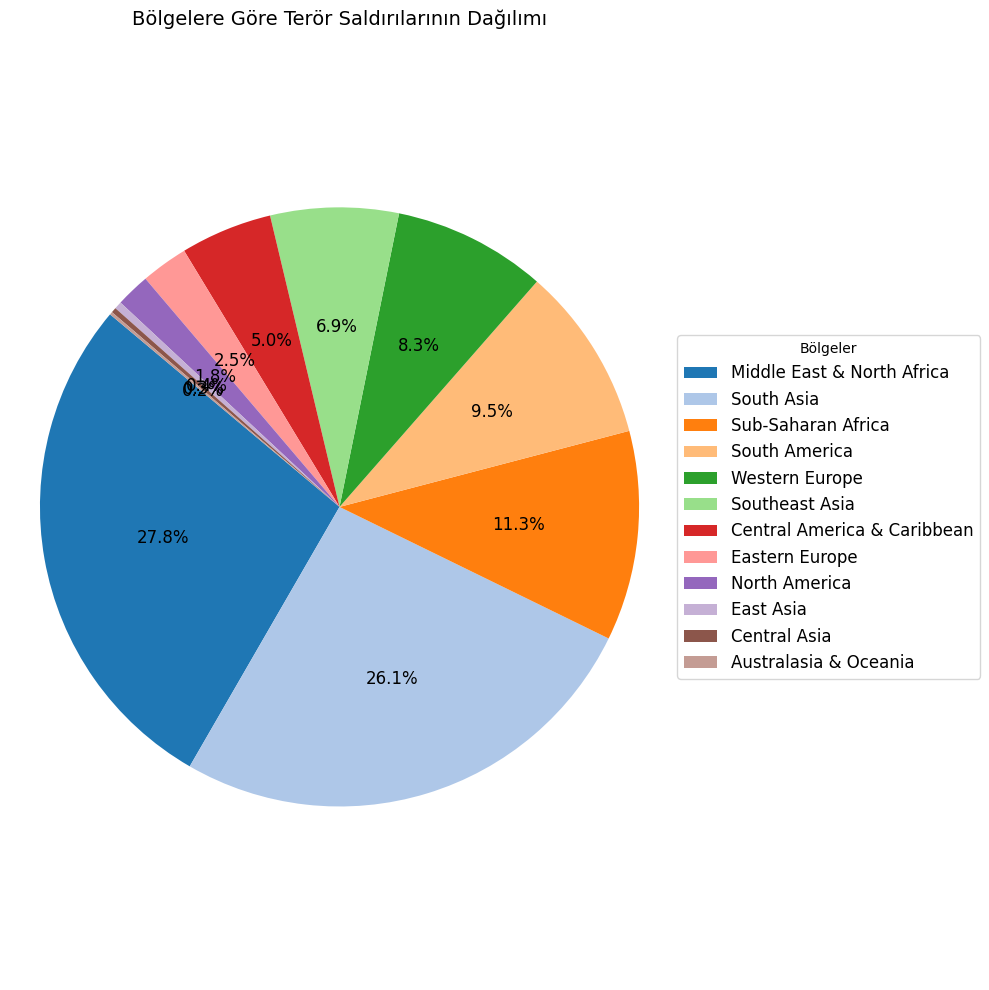

In [ ]:
region_counts = terror['Region'].value_counts()
colors = sns.color_palette('tab20', len(region_counts))

plt.figure(figsize=(10,10))
wedges, texts, autotexts = plt.pie(
    region_counts,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 12}
)

plt.legend(
    wedges,
    region_counts.index,
    title="Bölgeler",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=12
)

plt.title('Bölgelere Göre Terör Saldırılarının Dağılımı', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()

## **Yıllara ve Bölgelere Göre Saldırı Sayısı**

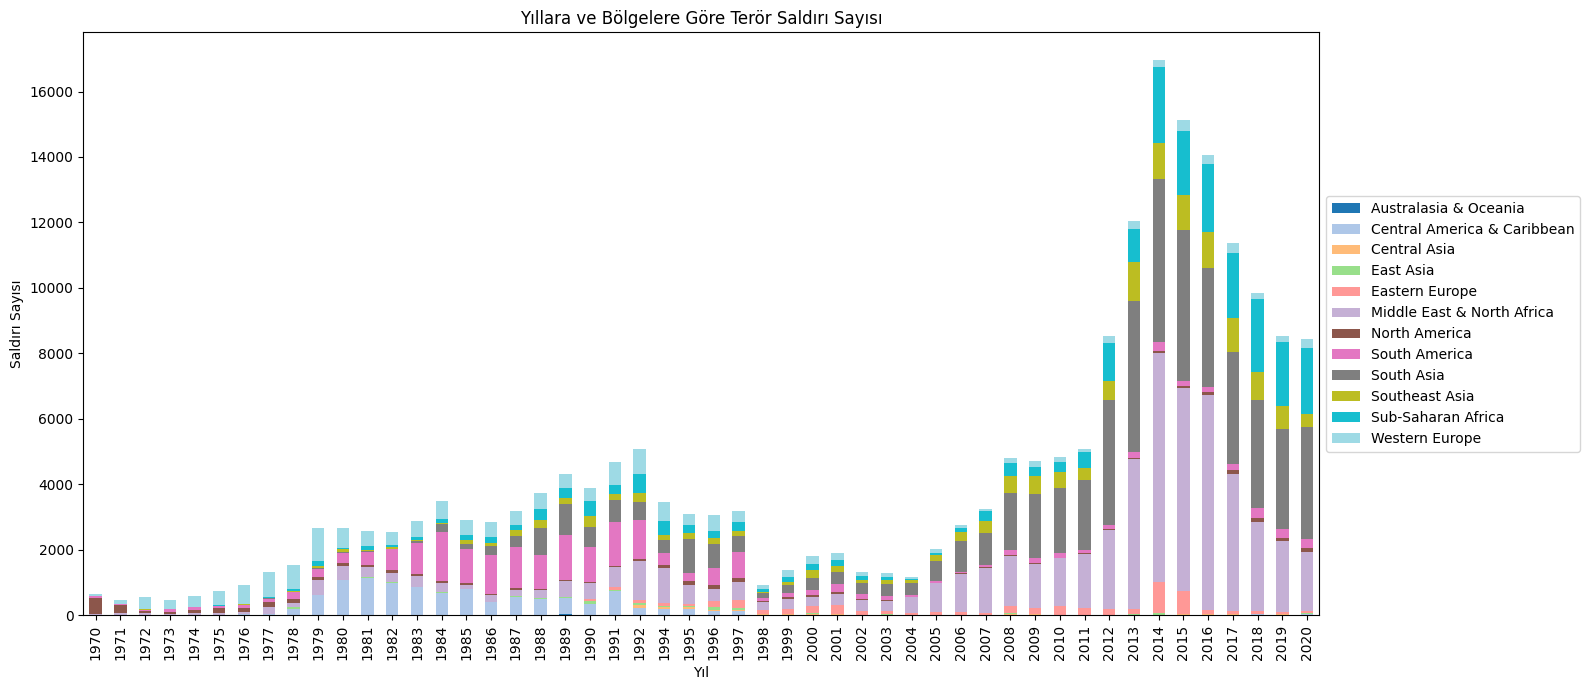

In [ ]:
region_year = terror.groupby(['Year','Region']).size().unstack().fillna(0)
region_year.plot(kind='bar', stacked=True, figsize=(16,7), colormap='tab20')
plt.title('Yıllara ve Bölgelere Göre Terör Saldırı Sayısı')
plt.xlabel('Yıl')
plt.ylabel('Saldırı Sayısı')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

## **En Aktif 10 Terör Örgütünün Yıllara Göre Saldırı Sayısı**

<Figure size 1400x600 with 0 Axes>

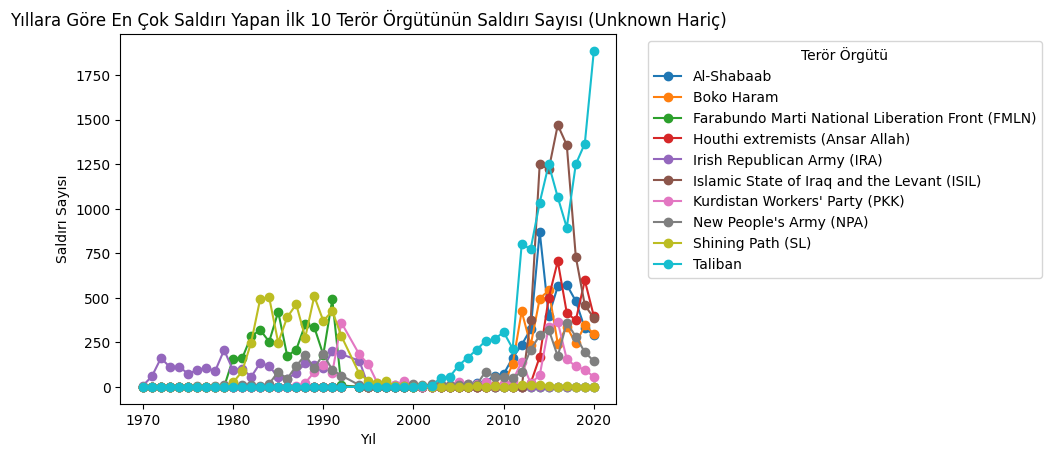

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# 'Unknown' grubunu çıkar ve en çok saldırı yapan ilk 10 örgütü seç
filtered_terror = terror[~terror['Group'].str.lower().eq('unknown')]

top_10_groups = filtered_terror['Group'].value_counts().head(10).index

# Yıllara göre saldırı sayısı (her örgüt için)
yearly_attacks = filtered_terror[filtered_terror['Group'].isin(top_10_groups)].groupby(['Year', 'Group']).size().unstack(fill_value=0)

yearly_attacks.plot(marker='o')
plt.title('Yıllara Göre En Çok Saldırı Yapan İlk 10 Terör Örgütünün Saldırı Sayısı (Unknown Hariç)')
plt.xlabel('Yıl')
plt.ylabel('Saldırı Sayısı')
plt.legend(title='Terör Örgütü', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## **Saldırı Tipine Göre Can Kaybı**

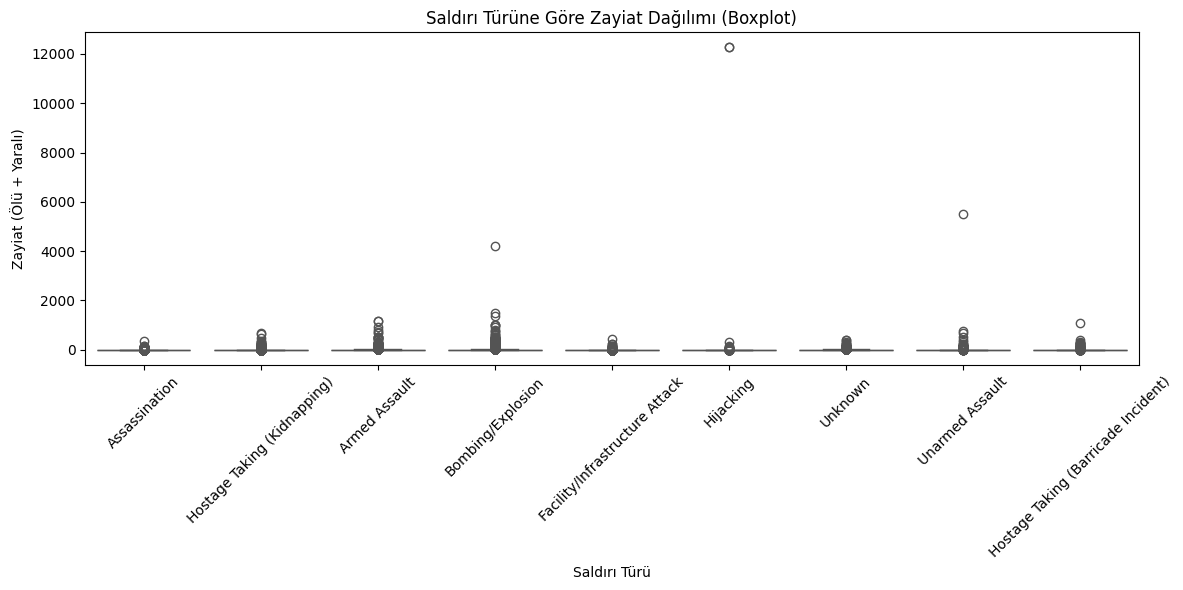

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='AttackType', y='casualities', data=terror[terror['casualities'].notna()], palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Saldırı Türüne Göre Zayiat Dağılımı (Boxplot)')
plt.xlabel('Saldırı Türü')
plt.ylabel('Zayiat (Ölü + Yaralı)')
plt.tight_layout()
plt.show()

## **Hedef Tipleri ve Silah Tipleri**

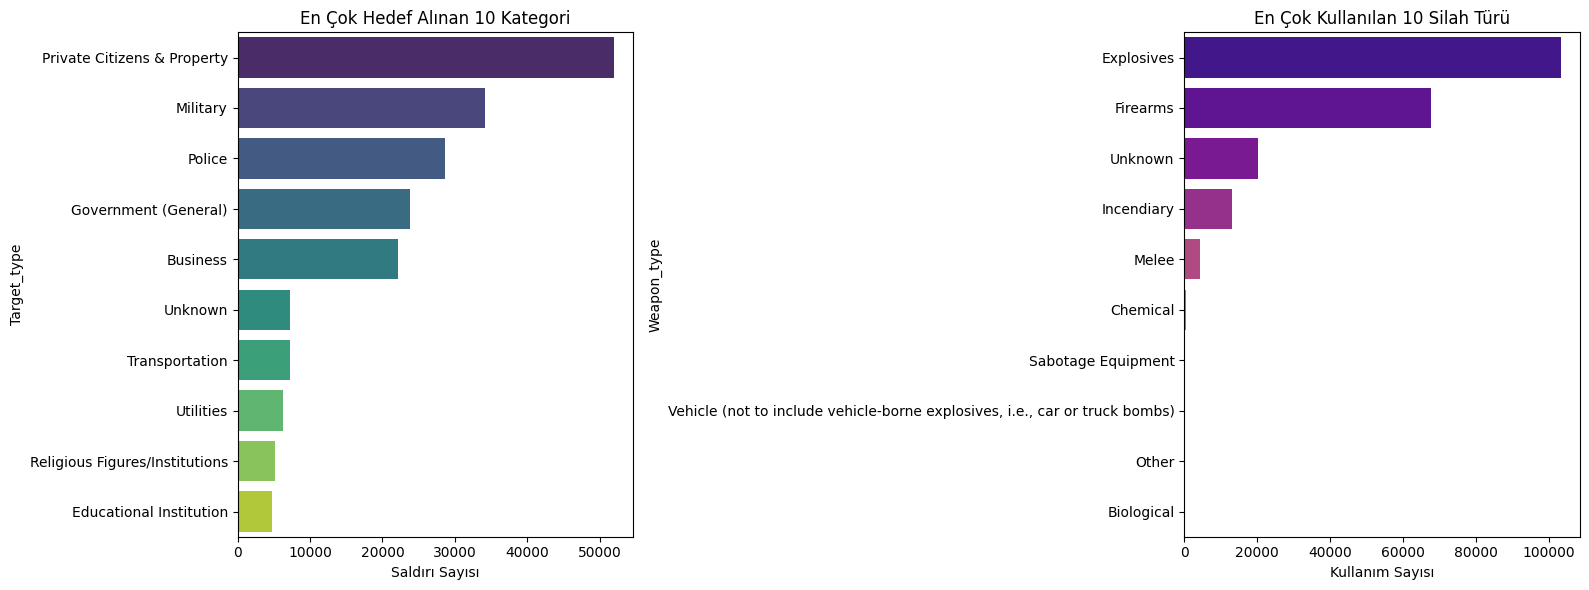

In [ ]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
target_types = terror['Target_type'].value_counts().head(10)
sns.barplot(x=target_types.values, y=target_types.index, palette='viridis')
plt.title('En Çok Hedef Alınan 10 Kategori')
plt.xlabel('Saldırı Sayısı')

plt.subplot(1, 2, 2)
weapon_types = terror['Weapon_type'].value_counts().head(10)
sns.barplot(x=weapon_types.values, y=weapon_types.index, palette='plasma')
plt.title('En Çok Kullanılan 10 Silah Türü')
plt.xlabel('Kullanım Sayısı')

plt.tight_layout()
plt.show()

## **Örgütlere Göre Saldırı Türü Dağılımı**

In [ ]:
df_filtered = df[df['gname'] != 'Unknown'].copy()

features = ['iyear', 'country_txt', 'attacktype1_txt',
            'targtype1_txt', 'weaptype1_txt', 'nkill',
            'nwound', 'property', 'success', 'suicide']
df_selected = df_filtered[features + ['gname']]

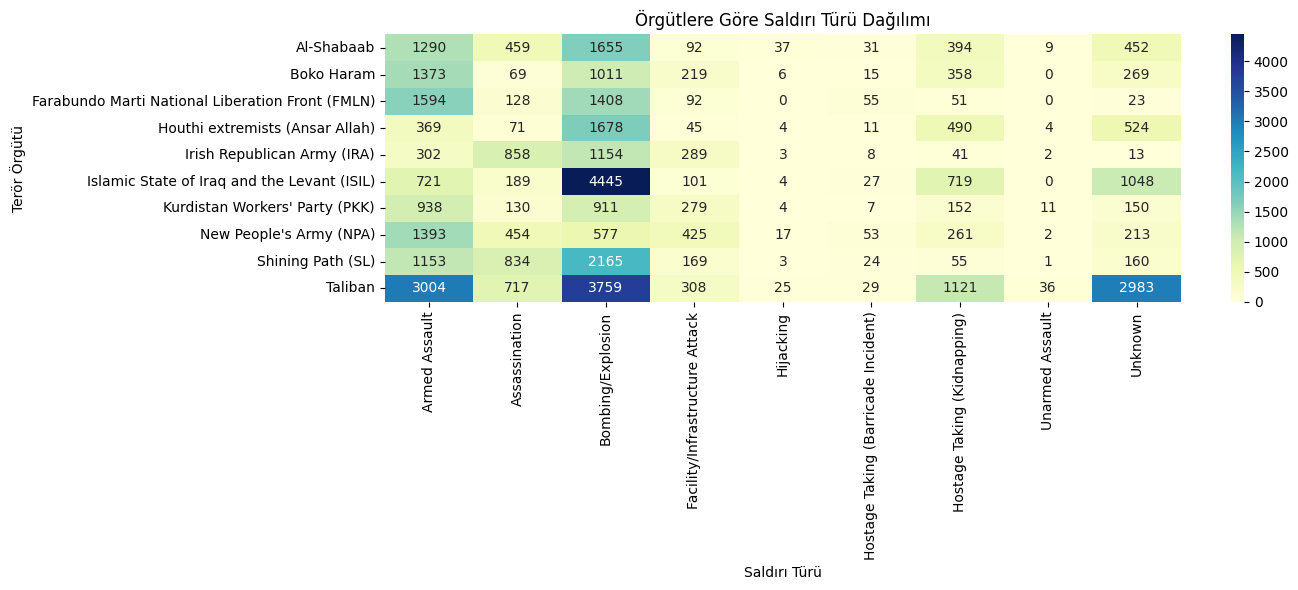

In [ ]:
attack_group_pivot = pd.pivot_table(df_top,
                                     values='iyear',
                                     index='gname',
                                     columns='attacktype1_txt',
                                     aggfunc='count',
                                     fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(attack_group_pivot, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Örgütlere Göre Saldırı Türü Dağılımı")
plt.xlabel("Saldırı Türü")
plt.ylabel("Terör Örgütü")
plt.tight_layout()
plt.show()

## **En Çok Olay Yaşanan Ülkelerde En Aktif Terör Örgütleri**

In [ ]:
df_filtered = df[df['gname'] != 'Unknown'].copy()

top_10_countries = df_filtered['country_txt'].value_counts().head(10).index.tolist()

df_top_countries = df_filtered[df_filtered['country_txt'].isin(top_10_countries)]

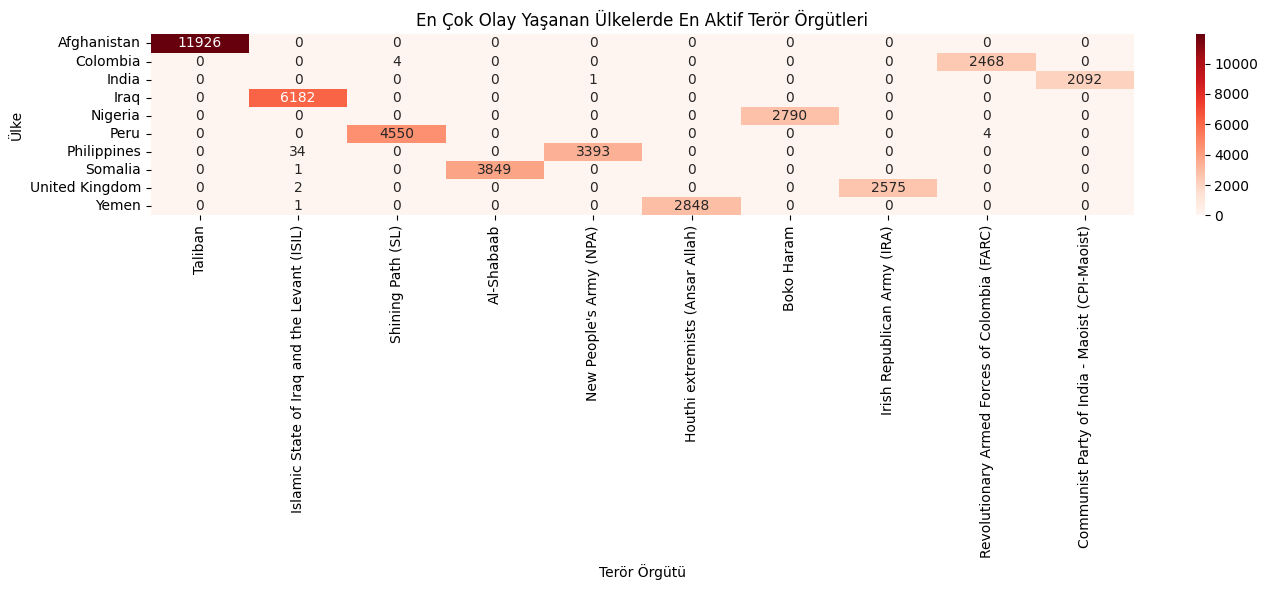

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot_country_group = df_top_countries.pivot_table(index='country_txt',
                                                    columns='gname',
                                                    values='iyear',
                                                    aggfunc='count',
                                                    fill_value=0)

top_groups = pivot_country_group.sum().sort_values(ascending=False).head(10).index
pivot_filtered = pivot_country_group[top_groups]

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_filtered, annot=True, fmt='d', cmap="Reds")
plt.title("En Çok Olay Yaşanan Ülkelerde En Aktif Terör Örgütleri")
plt.xlabel("Terör Örgütü")
plt.ylabel("Ülke")
plt.tight_layout()
plt.show()

## **Türkiye'de Yıllara Göre Terör Olayları**

In [ ]:
turkey_df = terror[terror['Country'] == 'Turkey']

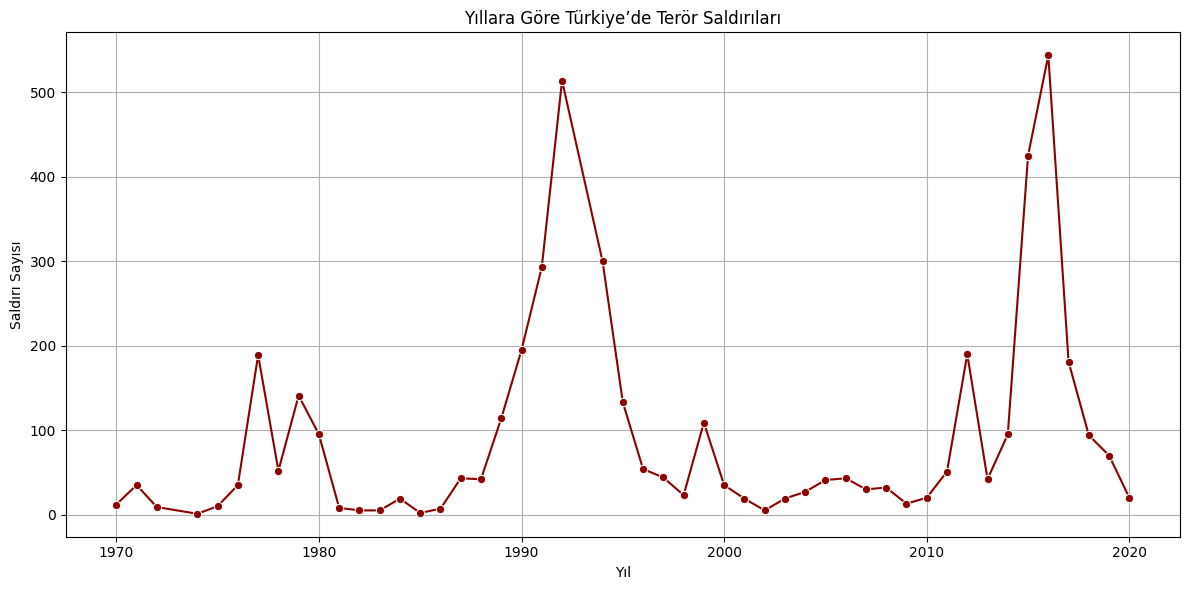

In [ ]:
turkey_by_year = turkey_df['Year'].value_counts().sort_index()
plt.figure(figsize=(12,6))
sns.lineplot(x=turkey_by_year.index, y=turkey_by_year.values, marker='o', color='darkred')
plt.title('Yıllara Göre Türkiye’de Terör Saldırıları')
plt.xlabel('Yıl')
plt.ylabel('Saldırı Sayısı')
plt.grid(True)
plt.tight_layout()
plt.show()

## **Türkiye'de Saldırı Türü ile Hedef Tipi Arasındaki İlişki**

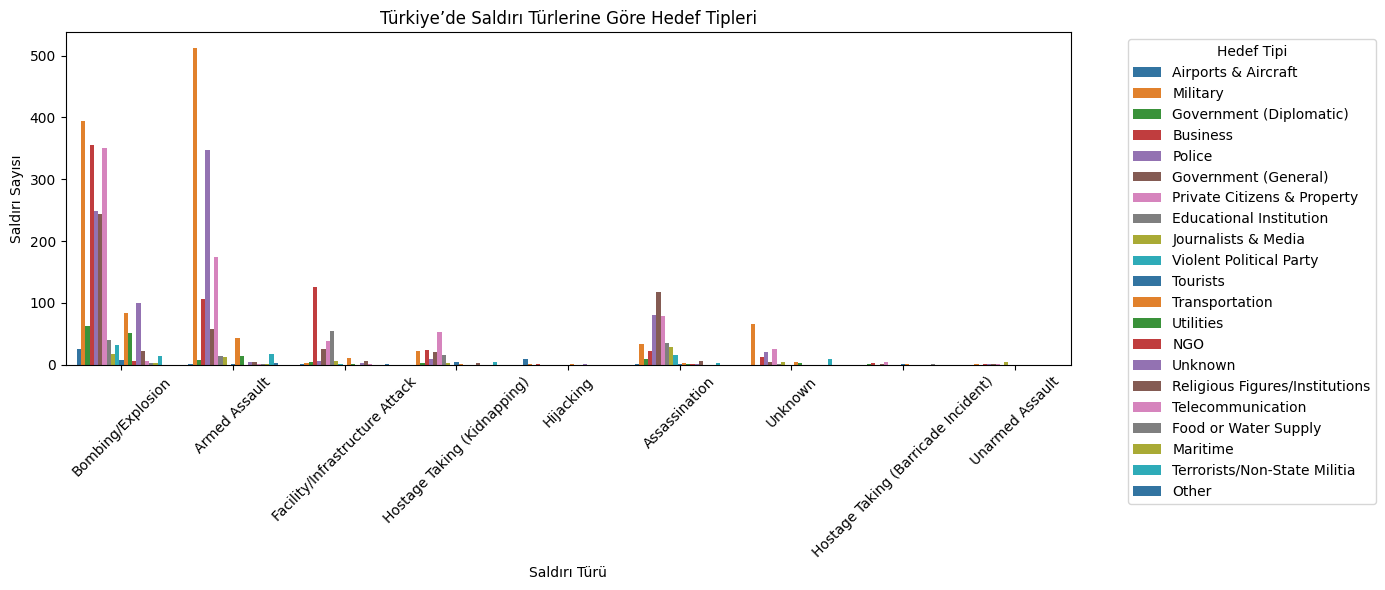

In [ ]:
plt.figure(figsize=(14,6))
sns.countplot(data=turkey_df, x='AttackType', hue='Target_type', palette='tab10')
plt.title('Türkiye’de Saldırı Türlerine Göre Hedef Tipleri')
plt.xticks(rotation=45)
plt.xlabel('Saldırı Türü')
plt.ylabel('Saldırı Sayısı')
plt.legend(title='Hedef Tipi', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## **Genel Özet**

In [ ]:
summary_stats = pd.DataFrame({
    'Toplam Saldırı': [len(terror)],
    'Toplam Ölü': [terror['Killed'].sum()],
    'Toplam Yaralı': [terror['Wounded'].sum()],
    'Toplam Kayıp': [terror['casualities'].sum()],
    'Etkilenen Ülke': [terror['Country'].nunique()],
    'Aktif Grup Sayısı': [terror['Group'].nunique()],
    'Farklı Saldırı Türü': [terror['AttackType'].nunique()],
    'Kapsanan Yıl Aralığı': [f"{terror['Year'].min()}-{terror['Year'].max()}"]
})

print("GLOBAL TERÖRİZM VERİSETİ ÖZET İSTATİSTİKLERİ")
print("=" * 50)
for column in summary_stats.columns:
    print(f"{column}: {summary_stats[column].iloc[0]}")

# En kritik 10 olayı bulalım
most_deadly_attacks = terror.nlargest(10, 'casualities')[['Year', 'Country', 'city', 'Group', 'Killed', 'Wounded', 'casualities']]
print("\nEN ÖLÜMCÜL 10 TERÖRİST SALDIRISI:")
print("-" * 50)
print(most_deadly_attacks.to_string(index=False))

GLOBAL TERÖRİZM VERİSETİ ÖZET İSTATİSTİKLERİ
Toplam Saldırı: 209706
Toplam Ölü: 479348.0
Toplam Yaralı: 585606.0
Toplam Kayıp: 989396.0
Etkilenen Ülke: 204
Aktif Grup Sayısı: 3725
Farklı Saldırı Türü: 9
Kapsanan Yıl Aralığı: 1970-2020

EN ÖLÜMCÜL 10 TERÖRİST SALDIRISI:
--------------------------------------------------
 Year       Country          city                                                                     Group  Killed  Wounded  casualities
 2001 United States New York City                                                                  Al-Qaida  1385.0  10878.0      12263.0
 2001 United States New York City                                                                  Al-Qaida  1385.0  10878.0      12263.0
 1995         Japan         Tokyo                                                            Aum Shinri Kyo    13.0   5500.0       5513.0
 1998         Kenya       Nairobi                                                                  Al-Qaida   224.0   4000.0   